In [36]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
from pyfinance import TSeries
import ffn

In [3]:
from hurst import compute_Hc, random_walk

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hurst import compute_Hc, random_walk

In [5]:
def ShannonFast(df):
    df=df[df!=0.0]
    shift_returns = df.shift(1)
    shift_returns2 = df.shift(2)
    shift_returns3 = df.shift(3)
    
    #df['test']  = np.sign(df['returns']).astype('str').dropna() + np.sign(df['shift_returns2']).astype('str').dropna() +  np.sign(df['shift_returns3']).dropna().astype('str')
    
    df =df.dropna(axis=0)
    
    Pattern  = np.sign(df.dropna()).astype('str') + np.sign(shift_returns2.dropna()).astype('str') +  np.sign(shift_returns3.dropna()).astype('str')
    
    Pattern=Pattern.dropna().str.replace('.0','')
    patternList = Pattern.dropna().str.replace('.0','').unique().tolist()
    total = 0.0
    ShannonPatterns = {}
    
    for e in patternList:
        ShannonPatterns[e] = 0

    for pattern in ShannonPatterns.keys():        
        value = (len(np.where(Pattern==pattern)[0]))
        ShannonPatterns[pattern] +=  value
        total += value
        
    
    ProbSum = 0.0
    for pattern in ShannonPatterns.keys():
        p = ShannonPatterns[pattern] / total        
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    return Shannon_val

def Shannon(df, patternSize):
    
    chunks = []
    for i in range(0, len(df)):
        chunks.append(df[i:i+patternSize])
    
    chunks = chunks[:-patternSize-1]
    
    
    chunks = [np.array2string(x) for x in chunks.copy()]
    
    
    
    
    chunks_set = list(set(chunks))
    
    
    visited = {}
    total = 0
    for el in chunks_set:
        if (el not in visited):
            f = chunks.count(el)
            visited[el] = f
            total = total + f
    ProbSum = 0.0
    for el in visited:
        p = visited[el]/total
        value = p * np.log2(p)
        #visited[el] = value
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    del visited, chunks
    
    
    
    return Shannon_val

def marketMeannes(df_):
    
    m = np.median(df_) 
    nh = 0
    nl = 0
    
    for i in range(1, len(df_)-1):
        Pt = df_[i]
        Py = df_[i-1]
        
        if (Py > m) & (Py > Pt):
            nl += 1
        elif (Py < m) & (Py < Pt):
            nh += 1
        else:
            None
    return (nl+nh)/(len(df_)-1)
        
    
    
def Momersion(df):
    #print(np.where(df == 1)[0])
    #df = df['returns'].copy() * df['returns'].shift(1)
    df = df.copy() * df.shift(1)
    
    df = df.dropna()
    df = np.sign(df)
    pos = len(np.where(df == 1)[0])
    neg = len(np.where(df == -1)[0])
    #zero = len(np.where(df == 0.0)[0])
    if (pos + neg) == 0.0:
        return -1.0
    #print(pos, neg)
    mom = (pos / (pos+neg )) #*100.0
    return mom
# https://pypi.org/project/hurst/
def hurst(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst

def MomersionDouble(df):

    df = df[df!=0.0]
    shift_returns = df.shift(1).fillna(0)
    shift_returns2 = df.shift(2).fillna(0)
    shift_returns3 = df.shift(3).fillna(0)
    Pattern = np.sign(shift_returns * shift_returns2)
    Pattern2= np.sign(shift_returns2 * shift_returns3)
    df = df.dropna()

    pp = len(np.where( (Pattern == 1 ) & (Pattern2 == 1 ) )[0])
    pm = len(np.where( (Pattern == 1 ) & (Pattern2 == -1 ) )[0])
    mp = len(np.where( (Pattern == -1 ) & (Pattern2 == 1 ) )[0])
    mm = len(np.where( (Pattern == -1 ) & (Pattern2 == -1 ) )[0])

    total = (pp+pm-mp-mm)/(df.count()-1.0)
    #threshUp = total>=np.sqrt(len(df))

    return total #(total, len(df), np.sqrt(len(df)))

def proportion(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return pp/mm
    
def proportionPos(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return 100.0 * pp/(pp+mm) 

def autoCorrel(df, lag):
    return pd.Series.autocorr(df, lag)


def hurstF(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst


def hurstF2(p):
    lags = range(2,100)


    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

def hurstF3(series):
   

    #H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.na).dropna(), kind='price', simplified=True)
    H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.nan).dropna(), kind='random_walk', simplified=False)
    return H

def hurstF4(series):
   
    
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    return H



In [6]:
def generateRWI2(df):
    MomVal = Momersion(df[['returns']]) 
    MomDouble = MomersionDouble(df['returns'])
 
    h1 =  hurstF(df['price'])
    h2 =  hurstF2(df['price'])
    h3 =  hurstF3(df['price'])

    h4 = hurstF4(df['price'])
   
  
    #df = df.copy().join(autoCorr_features(df[['returns']].copy()), rsuffix='_suka_')
    
    MMIR = marketMeannes(df['returns'])
    
    MMIP = marketMeannes(df['price'])
    ShannonVal = ShannonFast(df['returns'])
    prop = proportionPos(df['returns'])
    correl_1 = autoCorrel(df.returns, 1)
    correl_2 = autoCorrel(df.returns, 2)
    correl_3 = autoCorrel(df.returns, 3)
    correl_4 = autoCorrel(df.returns, 4)
    correl_5 = autoCorrel(df.returns, 5)
    correl_10 = autoCorrel(df.returns, 10)
    correl_20 = autoCorrel(df.returns, 20)
    correl_100 = autoCorrel(df.returns, 100)
    correl_list = [correl_1, correl_2, correl_3, correl_4, correl_5, correl_10, correl_20, correl_100]
    
    var_std = df['returns'].std()
    var_mean = df['returns'].mean()
    var_median = df['returns'].mean()
    
    
    return [MomVal, MomDouble, h1, h2, h3, h4, MMIR, MMIP, ShannonVal, prop, var_std, var_mean, var_median] + correl_list

In [7]:
def generate_features(df):
    df.columns = ['price']
    
    df['returns'] = np.log(df['price']/df['price'].shift(1))
    
    df['ROC_2'] =  np.log(df['price'].copy()).pct_change(2)
    
    df['ROC_3'] = np.log(df['price'].copy()).pct_change(3)
    df['ROC_5'] = np.log(df['price'].copy()).pct_change(5)
    df['ROC_20'] = np.log(df['price'].copy()).pct_change(20)
    df['ROC_50'] = np.log(df['price'].copy()).pct_change(50)
    df['ROC_100'] = np.log(df['price'].copy()).pct_change(100)
    #df['ROC_200'] = np.log(df['price'].copy()).pct_change(200)
    #df['ROC_300'] = np.log(df['price'].copy()).pct_change(300)
    #df['ROC_500'] = np.log(df['price'].copy()).pct_change(500)
    
    
    df['abs_returns'] = np.abs( np.log(np.abs(df['price'].copy())).pct_change())
    

    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

In [8]:
### generate and stitch dataset

In [9]:
def transform_series(tmp):
    #tmp = [e[0] if (type(e)==np.ndarray) else e for e in tmp.copy()]
    df = pd.DataFrame(np.asarray(tmp)+100)
    scaler = MinMaxScaler(feature_range=(0.0, 1.0))
    df_ = scaler.fit_transform(df)
    df_ = pd.DataFrame(df_, columns=df.columns,index=df.index)
    df = (100+df_*100)
    return df

In [10]:
plt.plot(transform_series(random1)) 

NameError: name 'random1' is not defined

In [93]:
lk=50
random1 = transform_series(random_walk(1000,proba=0.50,  min_lookback=lk, max_lookback=lk))
random2 = transform_series(random_walk(1000,proba=0.50,  min_lookback=lk, max_lookback=lk))
mr = transform_series(random_walk(1000,proba=0.30,  min_lookback=lk, max_lookback=lk))
random3=transform_series(random_walk(1000,proba=0.50,  min_lookback=lk, max_lookback=lk))
trend = transform_series(random_walk(1000,proba=0.70,  min_lookback=lk, max_lookback=lk))
random4 = transform_series(random_walk(1000,proba=0.50,  min_lookback=lk, max_lookback=lk))

In [242]:
series_list = [random1.to_log_returns().dropna(), random2.to_log_returns().dropna(), mr.to_log_returns().dropna(), random3.to_log_returns().dropna(), trend.to_log_returns().dropna(), random4.to_log_returns().dropna()]

In [14]:
import pickle

In [243]:
main = pd.concat(series_list, axis=0).reset_index(drop=True).cumsum()

In [244]:
main = 100*main + 100

In [15]:
main =pd.read_pickle('combined series main.pkl')

In [ ]:
# hurst says its random or mean reverting
# positive proportion 88%, 7.9 more than negatives
# momersion 99
# 51.7
# Meannes returns: 74%
# MMI price 49.8

In [246]:
del df

In [16]:
returns = main.pct_change().rename(columns={0:'returns'}).dropna()

In [20]:
results = []
df=main.copy()
res = generate_features(df)
df = df.replace([np.inf, -np.inf],0).fillna(0)

df['shift_returns'] = df['returns'].shift(-1).dropna()
df = df[df.shift_returns != 0.0].dropna()
y = df.iloc[:, [-1]]
y.shift_returns = np.sign(y.shift_returns)
X = df.iloc[:, 0:7]

rwi_list = generateRWI2(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#X_train =X[0:1150]
#y_train = y[0:1150]
#X_test = X[1200:]
#y_test = y[1200:]

clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                             random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

rwi_list.append(score)
results.append(rwi_list)


C:\Users\lexik\.conda\envs\quant\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\lexik\.conda\envs\quant\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [21]:
results[0]

[0.5169420797863462,
 0.03388415957269237,
 0.48983419625126473,
 0.3778312552413034,
 0.5036031857503012,
 0.5308460090981819,
 0.744826435246996,
 0.49833110814419224,
 2.986103951504071,
 53.771695594125504,
 0.0114600370324939,
 0.00016542435361409624,
 0.00016542435361409624,
 0.015931384033841544,
 -0.005442985170125989,
 0.0027059113742999618,
 -0.06619070269837102,
 0.010443794577420349,
 0.015731964882079976,
 0.0008675868499522726,
 0.017046202887153854,
 0.5556173526140156]

In [22]:
# r, r, Mean-Reversal, random, trend, random

In [23]:
cols = ['MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'ShannonVal', 'prop', 'var_std', 'var_mean', 'var_median',   'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,   'score']

In [24]:
accuracy_df = pd.DataFrame(results, columns=cols) #.corr(method='spearman')['score'].sort_values()

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
accuracy_df.T

,0
MomVal,0.516942
MomDouble,0.033884
h1,0.489834
h2,0.377831
h3,0.503603
h4,0.530846
MMIR,0.744826
MMIP,0.498331
ShannonVal,2.986104
prop,53.771696


In [27]:
# accuracy closer to prop, MomVal, h4


In [28]:
import pickle

In [29]:
accuracy_model = pickle.load(open('accuracy_prediction.sav', 'rb'))

In [30]:
accuracy_model.predict(accuracy_df.drop(columns=['prop', 'var_std', 'var_mean', 'var_median']))

array([0.49383852])

In [31]:
#### Rolling husrt

In [37]:
main = main.rename(columns={0:'price'})

In [38]:
main['MA'] = main.price.rolling(300).mean()

In [39]:
main['returns'] = main.price.to_log_returns().fillna(0)

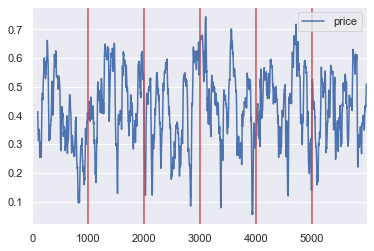

In [40]:
main[['price']].rolling(100).apply(hurstF).plot()
plt.axvline(1000, color='r')
plt.axvline(2000, color='r')
plt.axvline(3000, color='r')
plt.axvline(4000, color='r')
plt.axvline(5000, color='r')

In [41]:
# hurst F2 no use

In [42]:
# F3 catch  trend and mean-reversal, on 100
# F4 catch on 100
# F4 catch on 200
# F4 is best on 300, 500
# F2 worked on 500 data points
# F3 on 900 mean reversal not bad

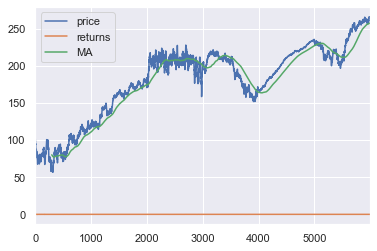

In [43]:
main.plot()


In [44]:
# momersion not bad on low tf
# can catch trends 
# bad for mean-reversals

## MMIR returns also good on long tf
# Shannon val not good at mean-reverting detection, or it doesn't work well


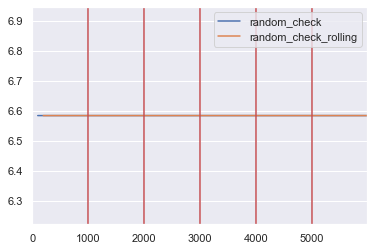

In [46]:
main['random_check'] = main[['returns']].rolling(100).apply(Shannon, args=[3], raw=True)
main['random_check_rolling'] = main['random_check'].rolling(100).mean()
main[['random_check', 'random_check_rolling']].plot()
plt.axvline(1000, color='r')
plt.axvline(2000, color='r')
plt.axvline(3000, color='r')
plt.axvline(4000, color='r')
plt.axvline(5000, color='r')

In [296]:
np.sqrt(1000)

31.622776601683793

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002CD59B92088>,
      dtype=object)

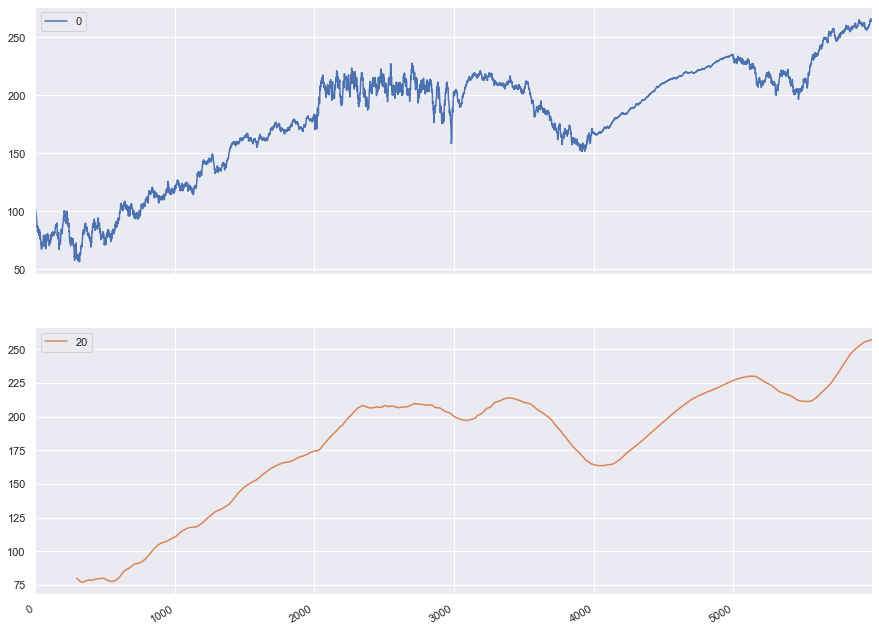

In [206]:
main.plot(subplots=(2,1), figsize=(15,12))